## Pharma Sales Time Series Analysis & Forecasting


## Import Libraries

In [327]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose



## Reading the Data

#### Data collected in 6 years (period Jan 2014- Oct 2019). 

Selected group of drugs (57 drugs) is classified to 8 Anatomical Therapeutic Chemical (ATC) Classification System categories:

* M01AB - Anti-inflammatory and antirheumatic products, non-steroids, Acetic acid derivatives and related substances

* M01AE - Anti-inflammatory and antirheumatic products, non-steroids, Propionic acid derivatives

* N02BA - Other analgesics and antipyretics, Salicylic acid and derivatives

* N02BE - Other analgesics and antipyretics, Pyrazolones and Anilides

* N05B - Psycholeptics drugs, Anxiolytic drugs

* N05C - Psycholeptics drugs, Hypnotics and sedatives drugs

* R03 - Drugs for obstructive airway diseases

* R06 - Antihistamines for systemic use

In [328]:
#reading the data
monthly = pd.read_csv('salesmonthly.csv')

### Explore Data

In [329]:
monthly.describe()

,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
count,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
mean,149.992000,116.514286,115.020843,892.542071,262.104286,17.842857,167.675000,86.662571
std,31.485325,27.889336,31.245899,338.843908,85.105492,8.481242,81.767979,45.859336
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,137.490000,103.518250,94.375000,648.187500,223.750000,12.000000,112.000000,49.875000
50%,154.635000,114.840000,117.225000,865.824500,250.300000,18.000000,160.000000,74.100000
75%,169.000000,128.359750,133.837500,1061.580000,293.650000,23.000000,218.250000,119.807500
max,211.130000,222.351000,191.600000,1856.815000,492.000000,50.000000,386.000000,213.040000


The study involves forecasting sales for eight distinct groups of pharmaceutical products

In [330]:
monthly.head()

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
0,31/01/14,127.69,99.090,152.100,878.030,354.0,50,112.0,48.2
1,28/02/14,133.32,126.050,177.000,1001.900,347.0,31,122.0,36.2
2,31/03/14,137.44,92.950,147.655,779.275,232.0,20,112.0,85.4
3,30/04/14,113.10,89.475,130.900,698.500,209.0,18,97.0,73.7
4,31/05/14,101.79,119.933,132.100,628.780,270.0,23,107.0,123.7


In [331]:
monthly.tail()

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
65,30/06/19,151.54,101.627,103.20,610.00,193.0,25,142.0,156.04
66,31/07/19,181.00,103.541,92.80,649.80,250.6,20,115.0,105.20
67,31/08/19,181.91,88.269,84.20,518.10,237.0,26,145.0,97.30
68,30/09/19,161.07,111.437,93.50,984.48,227.8,16,161.0,109.10
69,31/10/19,44.37,37.300,20.65,295.15,86.0,7,37.0,11.13


#### Extracting month and year from datum column

In [332]:
# Convert 'datum' to datetime, extract year and month, and then drop the 'datum' column
monthly['datum'] = pd.to_datetime(monthly['datum'])
monthly['year'] = monthly['datum'].dt.year
monthly['month'] = monthly['datum'].dt.month
monthly.drop('datum', axis=1, inplace=True)
monthly.head() 

C:\Users\beena\AppData\Local\Temp\ipykernel_5540\2566179269.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  monthly['datum'] = pd.to_datetime(monthly['datum'])


,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,year,month
0,127.69,99.090,152.100,878.030,354.0,50,112.0,48.2,2014,1
1,133.32,126.050,177.000,1001.900,347.0,31,122.0,36.2,2014,2
2,137.44,92.950,147.655,779.275,232.0,20,112.0,85.4,2014,3
3,113.10,89.475,130.900,698.500,209.0,18,97.0,73.7,2014,4
4,101.79,119.933,132.100,628.780,270.0,23,107.0,123.7,2014,5


### Outlier Detection

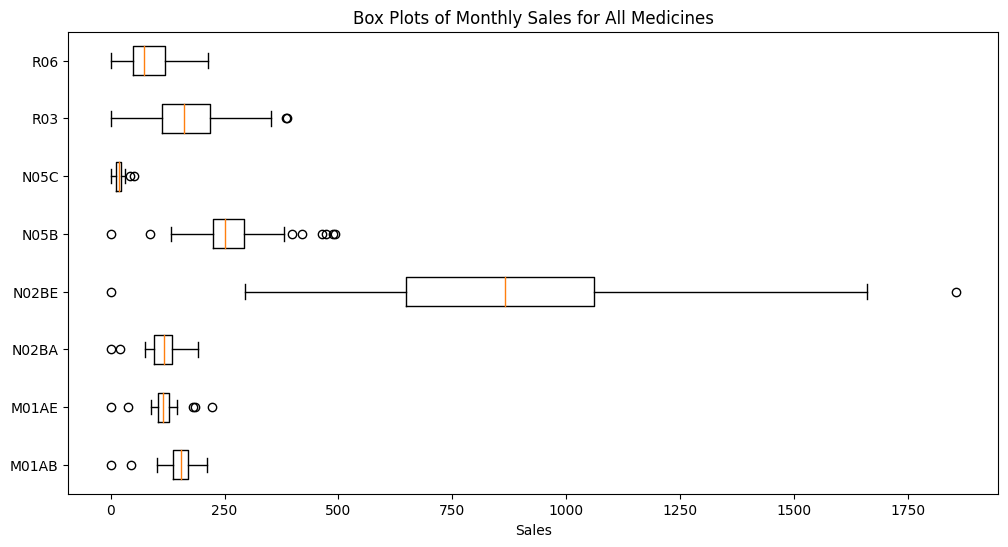

In [333]:
# List of medicine columns
medicine_columns = ['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06']

# Create a box plot for all medicines
plt.figure(figsize=(12, 6))
plt.boxplot([monthly[medicine] for medicine in medicine_columns], labels=medicine_columns, vert=False)
plt.title('Box Plots of Monthly Sales for All Medicines')
plt.xlabel('Sales')
plt.show()

In [334]:
# Check for zero values in the entire DataFrame
zero_values = (monthly == 0).sum()

# Display the count of zero values for each column
print("Zero Values in Each Column:")
print(zero_values)

# Check if there are any zero values in the entire DataFrame
if zero_values.sum() == 0:
    print("No zero values in the DataFrame.")
else:
    print("There are zero values in the DataFrame.")


Zero Values in Each Column:
M01AB    1
M01AE    1
N02BA    1
N02BE    1
N05B     1
N05C     1
R03      1
R06      1
year     0
month    0
dtype: int64
There are zero values in the DataFrame.


In [335]:
for column in monthly.columns:
    mean_value = monthly[monthly[column] != 0][column].mean()
    monthly[column] = monthly[column].replace(0, mean_value)
monthly.describe()


,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,year,month
count,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
mean,152.165797,118.202899,116.687812,905.477464,265.902899,18.101449,170.105072,87.918551,2016.428571,6.357143
std,25.701131,24.046126,27.960530,321.095761,78.948607,8.200645,79.199967,44.639162,1.690309,3.417923
min,44.370000,37.300000,20.650000,295.150000,86.000000,5.000000,37.000000,11.130000,2014.000000,1.000000
25%,137.750000,103.526750,97.487500,650.440500,226.000000,12.000000,112.750000,51.050000,2015.000000,3.250000
50%,154.635000,114.976500,117.225000,872.964500,251.400000,18.000000,162.000000,75.700000,2016.000000,6.000000
75%,169.000000,128.359750,133.837500,1061.580000,293.650000,23.000000,218.250000,119.807500,2018.000000,9.000000
max,211.130000,222.351000,191.600000,1856.815000,492.000000,50.000000,386.000000,213.040000,2019.000000,12.000000


### Time Series Analysis 

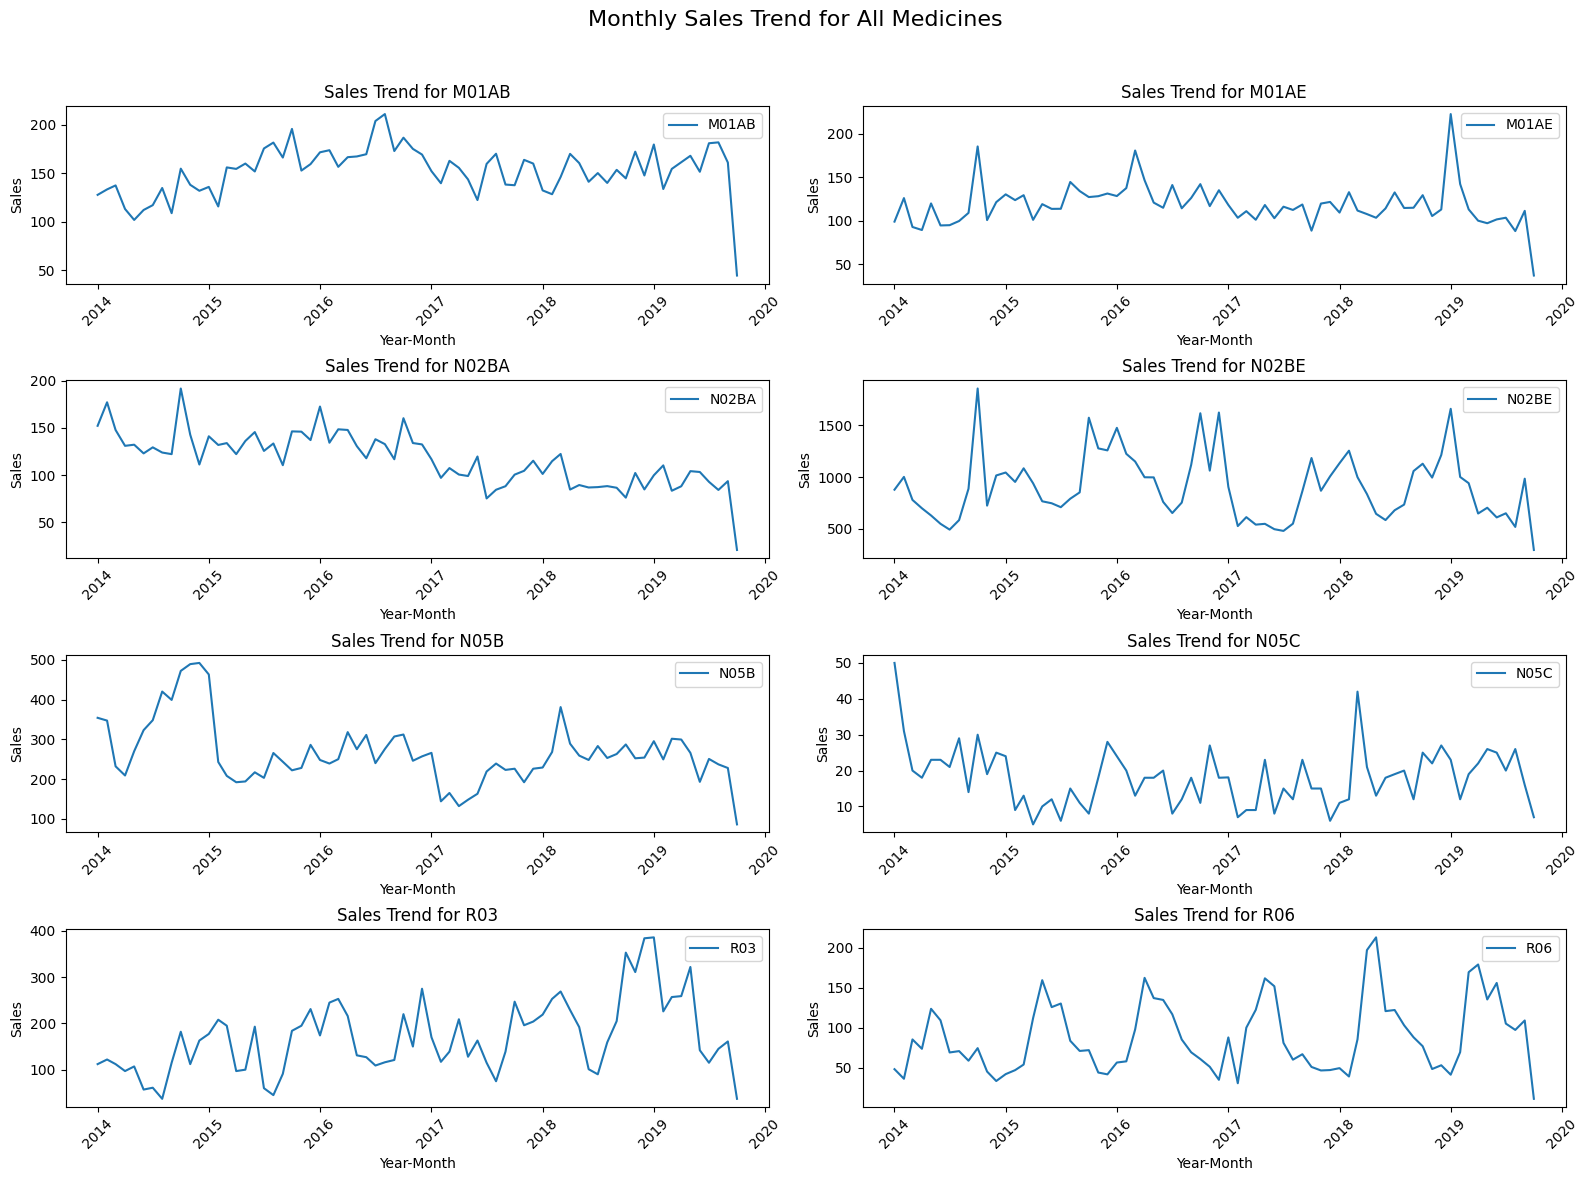

In [336]:
# Convert year and month to a datetime index
monthly['date'] = pd.to_datetime(monthly[['year', 'month']].assign(day=1))
monthly.set_index('date', inplace=True)

# Create a list of medicine columns to plot
medicine_columns = ['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06']

# Define the number of rows and columns for subplots
num_rows = 4  # Adjust as needed
num_cols = 2

# Create subplots for each medicine
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 12))
fig.suptitle('Monthly Sales Trend for All Medicines', fontsize=16)

for i, medicine in enumerate(medicine_columns):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    
    # Plot individual medicine sales
    ax.plot(monthly.index, monthly[medicine], label=medicine)
    ax.set_title(f'Sales Trend for {medicine}')
    ax.set_xlabel('Year-Month')
    ax.set_ylabel('Sales')
    ax.legend(loc='upper right')
    ax.tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)

# Show plots
plt.show()



### Extracting Seasonality of Medicine

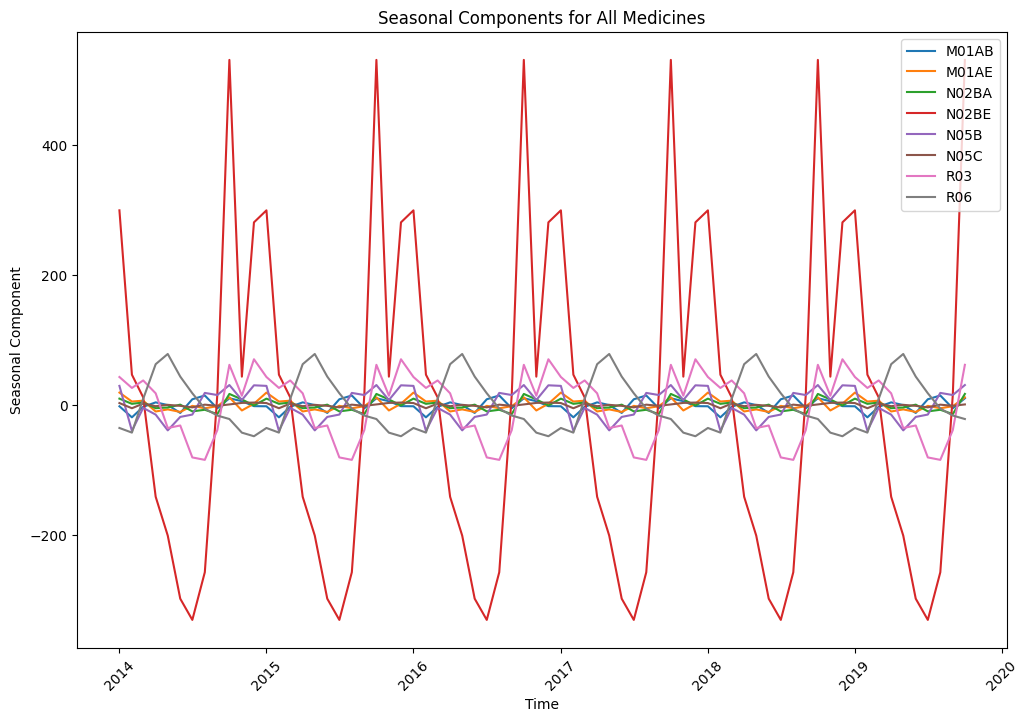

In [337]:
# Convert year and month to a datetime index
monthly['date'] = pd.to_datetime(monthly[['year', 'month']].assign(day=1))
monthly.set_index('date', inplace=True)

# Create a list of medicine columns to analyze
medicine_columns = ['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06']

# Dictionary to store seasonal components for each medicine
seasonal_components = {}

# Seasonal decomposition for each medicine and storage of seasonal components
for medicine in medicine_columns:
    decomposition = seasonal_decompose(monthly[medicine], model='additive', period=12)
    seasonal_components[medicine] = decomposition.seasonal

# Plot seasonal components for all medicines
plt.figure(figsize=(12, 8))
for medicine in medicine_columns:
    plt.plot(monthly.index, seasonal_components[medicine], label=medicine)

plt.title('Seasonal Components for All Medicines')
plt.xlabel('Time')
plt.ylabel('Seasonal Component')
plt.legend(loc='upper right')
plt.xticks(rotation=45)
plt.show()

## ADF TEST

Augmented Dickey Fuller test ( ADF Test) is a common statistical test used to test whether a given Time series is stationary or not

Stationarity is an important assumption for time series models, including forecasting models. 

A stationary time series has constant statistical properties over time, making it easier to model and forecast.

In [338]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Function to perform Augmented Dickey-Fuller test
def adf_test(timeseries, column_name):
    result = adfuller(timeseries, autolag='AIC')
    print(f'ADF Statistic for {column_name}:', result[0])
    print(f'p-value for {column_name}:', result[1])
    print(f'Critical Values for {column_name}:', result[4])
    print('\n')

# Iterate through each medicine count column
for column in ['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06']:
    adf_test(monthly[column], column)


ADF Statistic for M01AB: -3.599610991399502
p-value for M01AB: 0.005768469117199319
Critical Values for M01AB: {'1%': -3.528889992207215, '5%': -2.9044395987933362, '10%': -2.589655654274312}


ADF Statistic for M01AE: -5.914507845020934
p-value for M01AE: 2.591853023899133e-07
Critical Values for M01AE: {'1%': -3.528889992207215, '5%': -2.9044395987933362, '10%': -2.589655654274312}


ADF Statistic for N02BA: -1.132079057249546
p-value for N02BA: 0.702111126906604
Critical Values for N02BA: {'1%': -3.5319549603840894, '5%': -2.905755128523123, '10%': -2.5903569458676765}


ADF Statistic for N02BE: -4.605569570530058
p-value for N02BE: 0.00012615057919892914
Critical Values for N02BE: {'1%': -3.528889992207215, '5%': -2.9044395987933362, '10%': -2.589655654274312}


ADF Statistic for N05B: -2.6696763495090488
p-value for N05B: 0.07943417128828889
Critical Values for N05B: {'1%': -3.528889992207215, '5%': -2.9044395987933362, '10%': -2.589655654274312}


ADF Statistic for N05C: -6.95434

#### - Stationary Time Series:

A common assumption in many time series techniques is that the data are stationary.

If the ADF Statistic is below the critical values, and the p-value is less than the significance level (commonly 0.05), we can conclude that the time series is likely stationary.

For stationary time series (e.g., 'M01AB', 'M01AE', 'N02BE', 'N05C', 'R03'), we proceed with model fitting and forecasting.

#### - Non-Stationary Time Series:

If the ADF Statistic is above the critical values, or the p-value is greater than the significance level, you may fail to reject the null hypothesis, suggesting that the time series may not be stationary.
For non-stationary time series (e.g., 'N02BA', 'N05B', 'R06')

## Forecasting Future Sales 

#### BUILD AND COMPARE MODELS - ARIMA vs SARIMAX

## ARIMA MODEL

In [339]:
from statsmodels.tsa.arima.model import ARIMA

# Initialize an empty DataFrame to store 24 month forecasts
forecasted_values_arima  = pd.DataFrame(index=pd.date_range(start=monthly.index[-1] + pd.DateOffset(months=1), periods=24, freq='MS'))

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')
staionary_medicine_columns = ['M01AB', 'M01AE', 'N02BE', 'N05C', 'R03']

# Iterate through each drug category and perform forecasting
for drug in staionary_medicine_columns:
    # Fit an ARIMA model
    arima_model = ARIMA(monthly[drug], order=(1, 1, 1))
    arima_results = arima_model.fit()

    # Forecast the next 24 months
    forecast = arima_results.get_forecast(steps=24)

    # Store the forecasted values in the DataFrame
    forecasted_values_arima [drug] = forecast.predicted_mean

# Reset warnings to default
warnings.filterwarnings('default')

forecasted_values_arima 


,M01AB,M01AE,N02BE,N05C,R03
2019-11-01,108.059938,89.492336,589.901162,15.713633,86.606918
2019-12-01,124.088724,93.231393,739.660049,17.588565,118.656512
2020-01-01,128.122673,93.499258,815.750415,17.991998,139.362827
2020-02-01,129.137893,93.518448,854.410852,18.078806,152.740578
2020-03-01,129.393393,93.519823,874.053672,18.097485,161.383556
2020-04-01,129.457694,93.519922,884.033910,18.101504,166.967534
2020-05-01,129.473877,93.519929,889.104728,18.102369,170.575181
2020-06-01,129.477949,93.519929,891.681138,18.102555,172.905977
2020-07-01,129.478974,93.519929,892.990176,18.102595,174.411837
2020-08-01,129.479232,93.519929,893.655279,18.102603,175.384729


## SARIMAX MODEL

In [340]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


# Initialize an empty DataFrame to store 24 month forecasts
forecasted_values_sarimax  = pd.DataFrame(index=pd.date_range(start=monthly.index[-1] + pd.DateOffset(months=1), periods=24, freq='MS'))

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Iterate through each drug category and perform forecasting
for drug in staionary_medicine_columns:

    model = SARIMAX(monthly[drug], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    results = model.fit()

    # Forecast the next 24 months
    forecast = results.get_forecast(steps=24)

    # Store the forecasted values in the DataFrame
    forecasted_values_sarimax [drug] = forecast.predicted_mean

# Reset warnings to default
warnings.filterwarnings('default')

forecasted_values_sarimax 


,M01AB,M01AE,N02BE,N05C,R03
2019-11-01,110.829856,87.700456,548.743734,18.302353,123.905372
2019-12-01,111.560151,87.040248,833.808710,20.606913,211.283236
2020-01-01,130.519218,170.464514,1087.524180,21.391392,197.268377
2020-02-01,102.653014,127.661752,778.340572,12.878615,175.425831
2020-03-01,123.846450,100.705529,645.278004,20.556744,192.201238
2020-04-01,136.010399,89.212840,421.209770,16.460954,180.569274
2020-05-01,137.091363,72.898358,369.871933,19.121953,157.199276
2020-06-01,119.740983,82.227215,291.603856,17.936956,96.296481
2020-07-01,143.264651,93.311569,349.752072,15.516554,65.373199
2020-08-01,141.208880,62.780717,310.425527,19.177961,86.529740


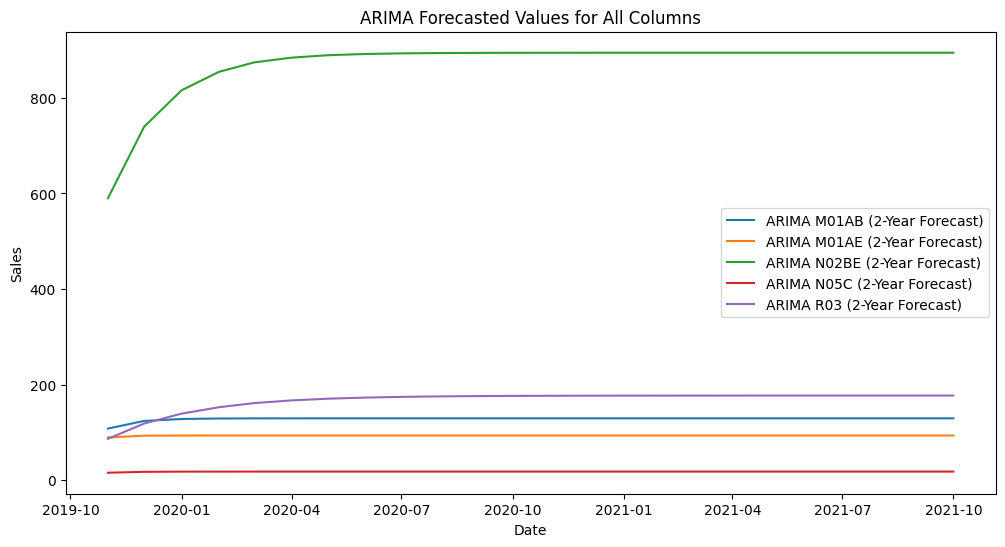

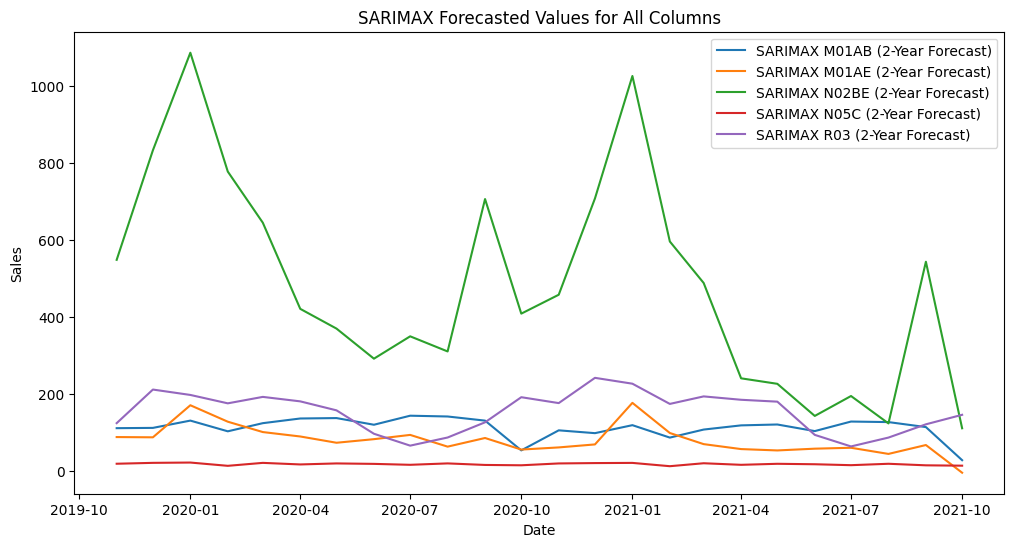

In [341]:
# Visualize the forecasted values for ARIMA
plt.figure(figsize=(12, 6))
for drug in forecasted_values_arima.columns:
    plt.plot(forecasted_values_arima.index, forecasted_values_arima[drug], label=f"ARIMA {drug} (2-Year Forecast)")

plt.title("ARIMA Forecasted Values for All Columns")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

# Visualize the forecasted values for SARIMAX
plt.figure(figsize=(12, 6))
for drug in forecasted_values_sarimax.columns:
    plt.plot(forecasted_values_sarimax.index, forecasted_values_sarimax[drug], label=f"SARIMAX {drug} (2-Year Forecast)")

plt.title("SARIMAX Forecasted Values for All Columns")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()
